In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor  # Thêm import này ngay từ đầu
from sklearn.metrics import mean_squared_error, r2_score
import glob
import os

def convert_number(value):
    if isinstance(value, str):
        value = value.replace(',', '').strip()
        
        if value == '--':
            return np.nan
            
        multiplier = {
            'T': 1e12,
            'B': 1e9,
            'M': 1e6
        }
        
        for unit, mult in multiplier.items():
            if value.endswith(unit):
                try:
                    return float(value[:-1]) * mult
                except ValueError:
                    return np.nan
                
        try:
            return float(value)
        except ValueError:
            return np.nan
    return value

# Đọc dữ liệu với xử lý lỗi
def load_data(data_path):
    csv_files = glob.glob(data_path)
    if not csv_files:
        raise ValueError(f"No CSV files found in {data_path}")
        
    dataframes = []
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            symbol = os.path.basename(file).split('_')[-1].split('.')[0]
            df['Symbol'] = symbol
            
            numeric_cols = df.columns[1:-1]
            for col in numeric_cols:
                df[col] = df[col].apply(convert_number)
                
            dataframes.append(df)
            print(f"Successfully loaded {file}")
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    return pd.concat(dataframes, ignore_index=True)

# Sử dụng hàm load_data
try:
    data = load_data('../Data/*.csv')
    print("\nData shape:", data.shape)
    print("\nFirst few rows:")
    print(data.head())
    print("\nMissing values:")
    print(data.isnull().sum())
except Exception as e:
    print(f"Error processing data: {e}")

Successfully loaded ../Data\detail_data_APP.csv
Successfully loaded ../Data\detail_data_APPS.csv
Successfully loaded ../Data\detail_data_ARM.csv
Successfully loaded ../Data\detail_data_BNZI.csv
Successfully loaded ../Data\detail_data_BROS.csv
Successfully loaded ../Data\detail_data_CYN.csv
Successfully loaded ../Data\detail_data_DDOG.csv
Successfully loaded ../Data\detail_data_DNUT.csv
Successfully loaded ../Data\detail_data_DUK.csv
Successfully loaded ../Data\detail_data_ELF.csv
Successfully loaded ../Data\detail_data_ENSC.csv
Successfully loaded ../Data\detail_data_FMCCH.csv
Successfully loaded ../Data\detail_data_GOOS.csv
Successfully loaded ../Data\detail_data_HAL.csv
Successfully loaded ../Data\detail_data_HSY.csv
Successfully loaded ../Data\detail_data_JMIA.csv
Successfully loaded ../Data\detail_data_LYFT.csv
Successfully loaded ../Data\detail_data_MDJH.csv
Successfully loaded ../Data\detail_data_MELI.csv
Successfully loaded ../Data\detail_data_MPW.csv
Successfully loaded ../Data

In [59]:
# Chỉ import các thư viện mới cần thiết cho học sâu
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

2.18.0


In [63]:
# Xác định các đặc trưng và biến mục tiêu
features = ['Market Cap', 'Enterprise Value', 'Price/Sales', 'Price/Book']
target = 'Forward P/E'

# Chia dữ liệu thành đặc trưng và biến mục tiêu
X = data_clean[features].values
y = data_clean[target].values

# Chia tập train và test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [64]:
# Xác định mô hình
model = Sequential([
    Dense(64, activation='relu', input_shape=(len(features),)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'), 
    Dense(1)
])

# Biên dịch mô hình
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='huber',  # Robust loss function
    metrics=['mae']
)


c:\Users\vuduy\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [65]:
# Huấn luyện mô hình
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 34.2439 - mae: 34.7439 - val_loss: 37.9367 - val_mae: 38.4367
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 34.1931 - mae: 34.6931 - val_loss: 37.8875 - val_mae: 38.3875
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 34.1439 - mae: 34.6439 - val_loss: 37.8401 - val_mae: 38.3401
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 34.0963 - mae: 34.5963 - val_loss: 37.7922 - val_mae: 38.2922
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 34.0491 - mae: 34.5491 - val_loss: 37.7430 - val_mae: 38.2430
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 34.0026 - mae: 34.5026 - val_loss: 37.6927 - val_mae: 38.1927
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 33.9566 - mae: 34.4566 - val_loss: 37.6424 - val_mae: 38.1424
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 33.9137 - mae: 34.4137 - val_loss: 37.5915 - val_mae: 38.0915
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51

In [66]:
# Đánh giá mô hình trên tập test
loss, mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'\nMean Squared Error (MSE): {loss}')
print(f'Mean Absolute Error (MAE): {mae}')


Mean Squared Error (MSE): 171.3855743408203
Mean Absolute Error (MAE): 171.8855743408203


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
R2 Score: -0.3371506119821166


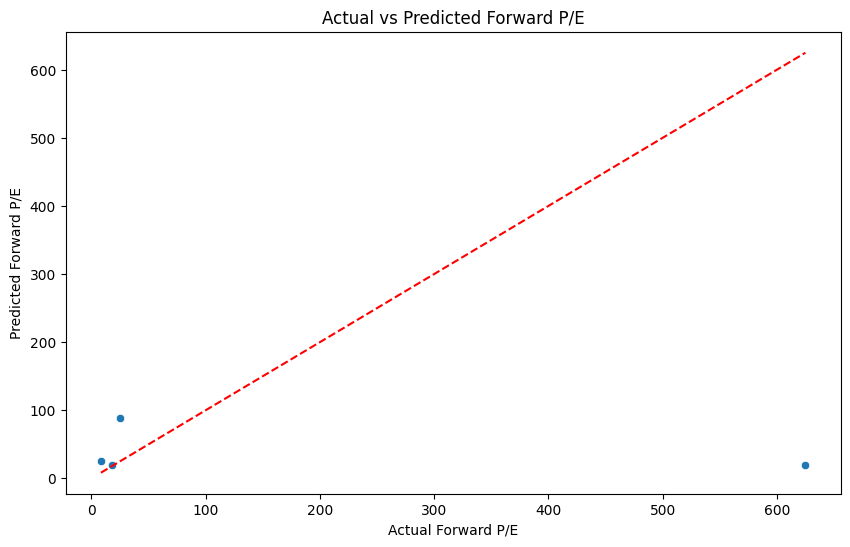

In [67]:
# Dự đoán trên tập test
y_pred = model.predict(X_test_scaled).flatten()

# Tính R2 Score
r2 = 1 - (np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))
print(f'R2 Score: {r2}')

# Trực quan hóa kết quả
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Forward P/E')
plt.ylabel('Predicted Forward P/E')
plt.title('Actual vs Predicted Forward P/E')
plt.show()

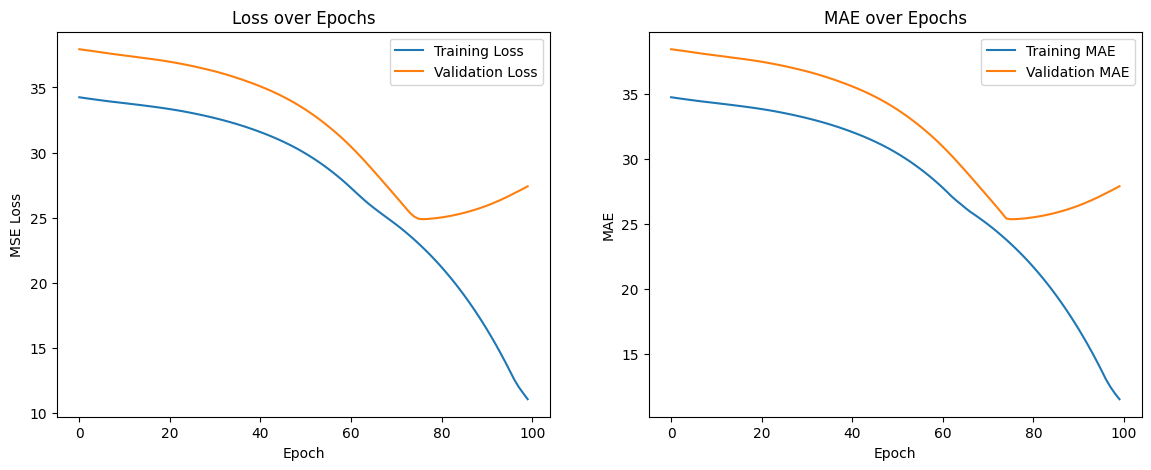

In [68]:
# Plot Loss và MAE qua các epoch
plt.figure(figsize=(14,5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

In [69]:
def predict_forward_pe(market_cap, enterprise_value, price_sales, price_book, scaler, model):
    # Tạo mảng đặc trưng
    input_data = np.array([[market_cap, enterprise_value, price_sales, price_book]])
    
    # Chuẩn hóa dữ liệu
    input_scaled = scaler.transform(input_data)
    
    # Dự đoán
    prediction = model.predict(input_scaled)
    
    return prediction[0][0]

# Ví dụ sử dụng hàm
symbol_to_predict = 'VST'  # Thay bằng mã cổ phiếu bạn muốn dự đoán
example_data = data_clean[data_clean['Symbol'] == symbol_to_predict]

if not example_data.empty:
    example_data = example_data.iloc[0]
    
    print("\nExample data being used:")
    print(f"Symbol: {example_data['Symbol']}")
    print(f"Date: {example_data['Date']}")
    print("\nFeature values:")
    for feature in features:
        print(f"{feature}: {example_data[feature]:.2e}")
    
    # Dự đoán Forward P/E
    predicted_pe = predict_forward_pe(
        market_cap=example_data['Market Cap'],
        enterprise_value=example_data['Enterprise Value'],
        price_sales=example_data['Price/Sales'],
        price_book=example_data['Price/Book'],
        scaler=scaler,
        model=model
    )
    
    print(f'\nPredicted Forward P/E: {predicted_pe:.2f}')
    print(f'Actual Forward P/E: {example_data["Forward P/E"]:.2f}')
    print(f'Prediction Error: {abs(predicted_pe - example_data["Forward P/E"]):.2f}')
else:
    print(f"No data available for symbol {symbol_to_predict}")


Example data being used:
Symbol: VST
Date: Current

Feature values:
Market Cap: 4.33e+10
Enterprise Value: 6.11e+10
Price/Sales: 3.24e+00
Price/Book: 1.39e+01
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Predicted Forward P/E: 12.60
Actual Forward P/E: 17.27
Prediction Error: 4.67


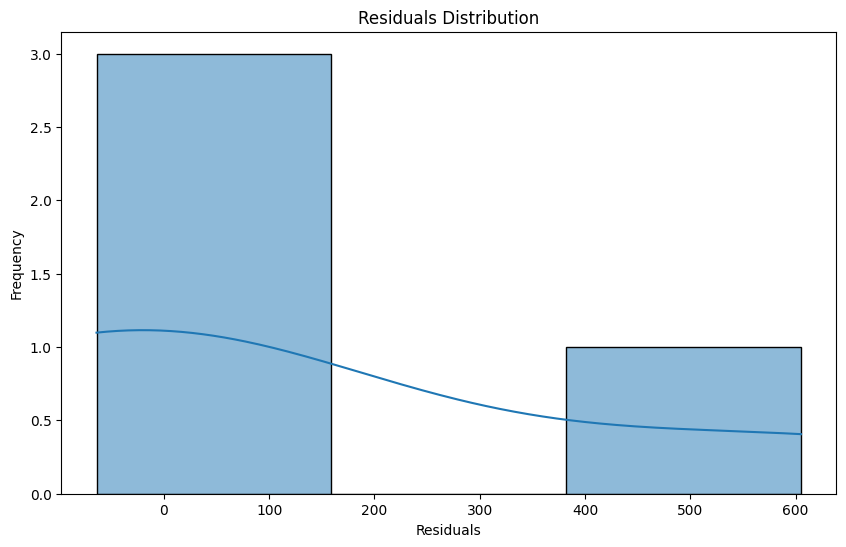

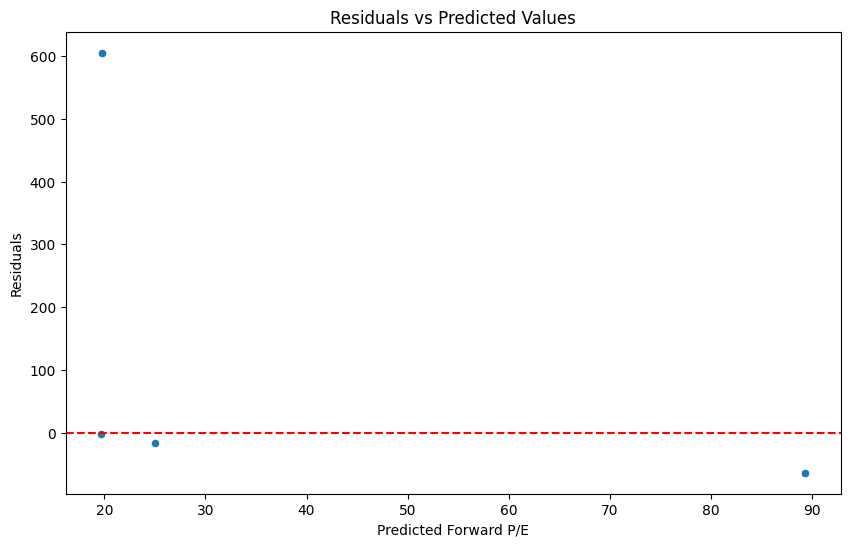

In [70]:
# Phân tích residuals
residuals = y_test - y_pred

# Histogram của residuals
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Scatter plot residuals vs predicted values
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Forward P/E')
plt.ylabel('Residuals')
plt.show()